<h1><b>Load Image

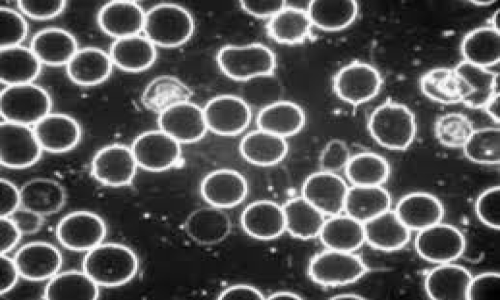

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img=cv2.imread('/content/drive/My Drive/PCD pict/uas.png')

dim_row=300 # ukuran baris
dim_col=500 # ukuran kolom
dim=(dim_col,dim_row)
img=cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # mengubah image awal kita sesuai dengan dimensi yang kita tetapkan
grayImage=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # dan mengubahnya menjadi grayscale

cv2_imshow(grayImage)

<h1><b>Segmentation using Otsu Method </b></h1>
Segmentasi pada kasus ini berfungsi membagi objek pada citra menjadi beberapa region karena kita ingin menghitung banyak region yang ada. 

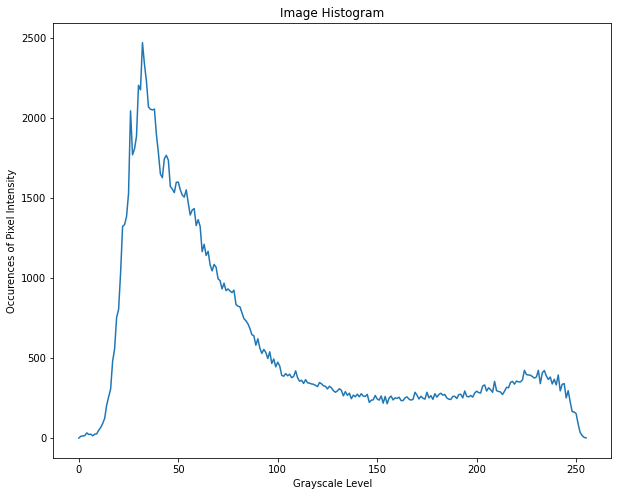

In [ ]:
import matplotlib.pyplot as plt

#Membuat histogram citra
hist=[0]*256 
for i in grayImage.flatten():
  hist[i]+=1

fig= plt.figure(figsize=(10,8))
plt.xlabel("Grayscale Level")
plt.ylabel("Occurences of Pixel Intensity")
plt.title("Image Histogram")
plt.plot(hist)

Selanjutnya adalah segmentasi dengan memanfaatkan otsu method. Otsu method merupakan teknik dari adaptive thresholding, dimana tujuannya adalah threshold segmentasi yang kita gunakan itu disesuaikan dengan histogram citra (nilai within class invariance) bukan hanya coba-coba, sehingga hasil yang diperoleh dapat tersegmentasi dengan lebih baik.

Threshold:  123


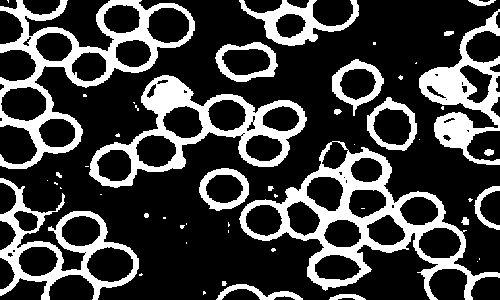

In [ ]:
wcv={} #dictionary untuk menyimpan within class invariance
for threshold in range(len(hist)): #memulai iterasi ke setiap nilai yang mungkin
  bg=hist[:threshold] #background
  fg=hist[threshold:] #foreground

  weight_bg=sum(bg)/sum(hist) #menghitung weight dari background
  weight_fg=sum(fg)/sum(hist) #menghitung weight dari foreground
  
  if sum(bg)==0: #untuk menghindari Zero Division Error, maka jika sum dari histogram kelompok background=0 maka mean dan variance=0
    mean_bg=0
    variance_bg=0
  else: #jika tidak 0, gunakan rumus berikut
    mean_bg=sum([i*hist[i] for i in range(len(bg))])/sum(bg)
    variance_bg=sum([((i-mean_bg)**2)*hist[i] for i in range(len(bg))])/sum(bg)
  
  if sum(fg)==0: #untuk menghindari Zero Division Error, maka jika sum dari histogram kelompok foreground=0 maka mean dan variance=0
    mean_fg=0
    variance_fg=0
  else: #jika tidak 0, gunakan rumus berikut
    mean_fg=sum([(i+threshold)*hist[i+threshold] for i in range(len(fg))])/sum(fg)
    variance_fg=sum([((i+threshold-mean_fg)**2)*hist[i+threshold] for i in range(len(fg))])/sum(fg)

  wcv[threshold]=weight_bg*variance_bg+weight_fg*variance_fg #menyimpan semua nilai within class variance setiap threshold

T=min(wcv.values()) #mencari nilai paling minimum dari semua within class variable
for i in wcv.keys():
  if wcv[i]==T:
    threshold=i #extract pixel intensity yang menjadi threshold berdasarkan wcv terkecil
    break
print("Threshold: ",threshold)

#proses mengubah nilai intensitas
for i in range(dim_row):
  for j in range(dim_col):
    if grayImage[i][j]<threshold: #jika nilai<threshold -> ubah ke 0, sebaliknya ubah ke 1
      grayImage[i][j]=0
    else:
      grayImage[i][j]=255

cv2_imshow(grayImage)

<h1><b>Morphological Operation with Erosion

Selanjutnya sebelum melanjutkan ke feature extraction, lebih baik kita melakukan sedikit morphological processing agar hasil yang sudah disegmentasi tersebut lebih baik ketika dikirimkan ke step selanjutnya. Pada kasus ini akan digunakan erosion agar noise seperti titik-titik kecil dapat dihilangkan atau minimalisir, kemudian agar tampilan bulatan pada sel darah dapat lebih terlihat pada hole-hole yang ada. Hole inilah yang menandakan keberadaan sel darah pada gambar. Selain itu bentuk yang kurang jelas dapat dihilangkan dengan metode erosion ini.

In [ ]:
def erosion(image,kernel):
  image_temp=np.zeros_like(image) #image_temp digunakan agar tidak menganggu file aslinya, untuk pengubahan menjadi binary image
  for i in range(dim_row):
    for j in range(dim_col):
      if(image[i][j]==255):
        image_temp[i][j]=1 # mengubah menjadi binary image dimana 0 akan menjadi 0, 255 menjadi 1
  # print(image_temp)

  image_processed=np.zeros((image.shape[0]+2, image.shape[1]+2),dtype=np.uint8) #digunakan untuk membangun padding pada input image
  image_processed[1:-1, 1:-1]=image_temp
  # print(image_processed)

  image_list=[]
  for i in range(image_processed.shape[0]-2):
    temp=[]
    for j in range(image_processed.shape[1]-2):
      kernel_temp=np.reshape(kernel,(1,-1)).flatten() #kernel diubah menjadi 1 dimensi
      block_temp=np.reshape(image_processed[i:i+len(kernel),j:j+len(kernel)],(1,-1)).flatten() #block images diubah menjadi 1 dimensi
      # print(kernel_temp,block_temp)
      new_temp=[]
      for k in range(len(kernel_temp)):
        if(kernel_temp[k]==1):  #untuk memilih kernel-kernel tertentu saja yang bernilai 1, diluar itu don't care tidak masuk perhitungan
          # print(kernel_temp[k],block_temp[k])
          new_temp.append(kernel_temp[k] and block_temp[k]) #melakukan operasi AND pada pasangan yang sudah diseleksi sebelumnya
      # print(new_temp)
      if (False in new_temp): # konsepnya adalah pada pasangan block-kernel semuanya harus sama-sama bernilai 1 (tidak boleh salah satunya 0)
        temp.append(0)
      else:
        temp.append(1)
    image_list.append(temp) #untuk menyimpan hasil akhir semua perhitungan
  
  new_images=np.reshape(image_list,(dim_row,dim_col))  #mengubah dimensi kembali ke ukuran awal
  for i in range(dim_row):
    for j in range(dim_col):
      if(new_images[i][j]==1):
        new_images[i][j]=255 #mengembalikan ke intensity awal dimana 1->255
  
  return new_images

Hasil Image Erosion: 


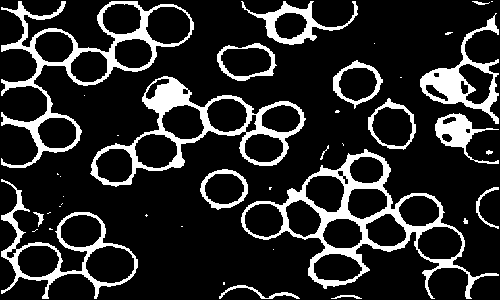

In [ ]:
# kernel=[[0,1,0],[1,1,1],[0,1,0]]
kernel=[[1,1,1],[1,1,1],[1,1,1]]
grayImage_erosion=erosion(grayImage,kernel)
print("Hasil Image Erosion: ")
cv2_imshow(grayImage_erosion)

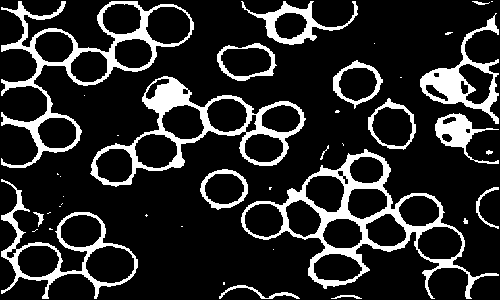

In [ ]:
#perlu mengubah nilai dari pixel intensity ke dalam uint8 agar menjadi 8-bit images sehingga dapat dijalankan blob detector.
final_image = (grayImage_erosion).astype('uint8')
cv2_imshow(final_image) #tidak ada perubahan berarti karena hanya mengubah tipe data intensitas

<h1><b>Blob Detection</b></h1>
Terakhir ada melakukan blob detection. Penggunaan blob detection ini disesuaikan dengan kasus dimana menghitung banyak sel darah merah yang notabene berbentuk bulatan-bulatan sehingga cukup cocok menggunakan detection ini. Pada blob detection ini saya menggunakan library bawaan dari cv2 yaitu SimpleBlobDetector.

Banyak sel darah:  42


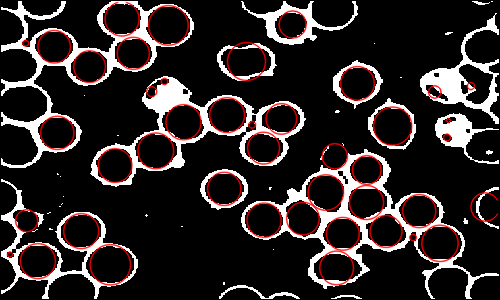

In [ ]:
#melakukan setting parameter
params = cv2.SimpleBlobDetector_Params() 
params.minThreshold=1
params.maxThreshold=255
params.filterByArea=True
params.minArea=1
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia=False
  
#membangun detector berdasarkan parameter diatas
detector = cv2.SimpleBlobDetector_create(params) 
      
#melakukan blob detection
blob_detection = detector.detect(final_image) 
count_blobs = len(blob_detection) 
print("Banyak sel darah: ",count_blobs)  

#menggambarkan letak blob yang terdeteksi
blank = np.zeros((1, 1))  
draw_blobs = cv2.drawKeypoints(final_image, circle_detection, blank, (0, 0, 255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
cv2_imshow(draw_blobs)